In [10]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import seaborn as sns
import pandas as pd

In [11]:
stims = np.array([[0,0,0],
         [0,0,1],
         [0,1,0],
         [0,1,1],
         [1,0,0],
         [1,0,1],
         [1,1,0],
         [1,1,1]])

labels = np.array([
                    [0,0,0,0,1,1,1,1], # type 1
                    [0,0,1,1,1,1,0,0], # type 2
                    [1,1,1,0,0,1,0,0], # type 3
                    [1,1,1,0,1,0,0,0], # type 4
                    [1,1,1,0,0,0,0,1], # type 5
                    [1,0,0,1,0,1,1,0]  # type 6
                ])


In [132]:
runs_df = []
for problem in range(labels.shape[0]):
    for i in range(100):
        model = keras.Sequential([
            layers.Dense(5, activation="relu"),
            layers.Dense(1, activation="sigmoid")
        ])
        model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.005), loss="binary_crossentropy", metrics=["accuracy"])
        history = model.fit(stims, labels[problem], epochs=100, batch_size=8, verbose=False)
        run_df=pd.DataFrame(history.history)
        run_df['error']=1.0-run_df['accuracy']
        run_df['block']=run_df.index
        run_df['run']=i
        run_df['problem']=problem+1
        runs_df.append(run_df)
runs_df = pd.concat(runs_df)


In [108]:
runs_df.head()

,loss,accuracy,error,block,run,problem
0,0.663492,0.750,0.250,0,0,0
1,0.658746,0.625,0.375,1,0,0
2,0.655073,0.625,0.375,2,0,0
3,0.652146,0.625,0.375,3,0,0
4,0.649537,0.625,0.375,4,0,0


<AxesSubplot:xlabel='block', ylabel='error'>

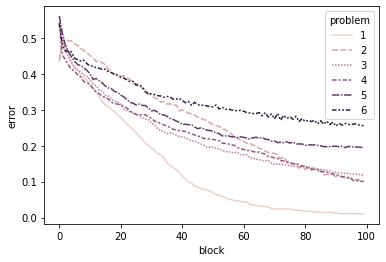

In [133]:
sns.lineplot(x='block',y='error',style='problem',hue='problem',data=runs_df.groupby(["block","problem"]).mean())

## Alcove Implementation

In [31]:
class ALCOVE(keras.Model):
    def __init__(self, exemplars, c=6.5, phi=2.5):
        # invoke super constructor and set params
        super().__init__()
        self.c = c
        self.phi = phi
        
        # define exemplars
        self.exemplars = tf.dtypes.cast(exemplars, tf.int32)
        self.ne = exemplars.shape[0]
        
        # association weights
        
        # attention weights 
        self.attn = np.ones((3,))/3.0
        
        # output layer
        self.output_layer = layers.Dense(1, activation="sigmoid", use_bias=False)  # later this should be two output and humble teacher loss
        


    def call(self, inputs):
        print("inputs = ", inputs)
        print("exemplars = ", self.exemplars)
        print("attention = ", self.attn)
        print(tf.math.abs(self.exemplars - inputs)*self.attn)
        
        # are the dimensions proper? do we need to reshape any tensors?
        
        hidden = tf.math.abs(self.exemplars - inputs)*self.attn
        hidden = tf.math.reduce_sum(hidden, axis=1)
        hidden = tf.math.exp(tf.math.scalar_mul(-self.c, hidden))
        print("shape of hidden: ", tf.shape(hidden))
        
        prob = self.output_layer(tf.math.scalar_mul(self.phi, hidden)) # activation fxn
        return prob

In [32]:
tstims = tf.convert_to_tensor(stims, dtype="int32")

model=ALCOVE(tstims)
model(tstims[7])

inputs =  tf.Tensor([1 1 1], shape=(3,), dtype=int32)
exemplars =  tf.Tensor(
[[0 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 1]
 [1 0 0]
 [1 0 1]
 [1 1 0]
 [1 1 1]], shape=(8, 3), dtype=int32)
attention =  [0.33333333 0.33333333 0.33333333]
tf.Tensor(
[[0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]], shape=(8, 3), dtype=int32)


TypeError: Cannot convert -6.5 to EagerTensor of dtype int32